In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model


## **Loads in:** <br>**<span style="color:lightcoral">Basic Stats:** the per-game box score player statistics.<br>**<span style="color:lightcoral">Advanced Stats:** the advanced analytics used to measure player performance.<br>**<span style="color:lightcoral">MVP Voting:** the results & rankings of MVP candidates.<br><br>All data is cumulative from all NBA Seasons from 1981-82 to 2023-24, <br>and each seasons data is taken from https://www.basketball-reference.com/

In [2]:
# Reads in Basic Player Stats (per game), Advanced Player Stats, and MVP Voting, Data is from all NBA Seasons from 1981-82 to 2023-24
# Data was taken as .csv files for each season from https://www.basketball-reference.com/, then formatted by adding season column and merging seasons with formatdata.ipynb
BasicStatsOG = pd.read_csv("./csv/basicstats/combinedseasonsbasicstats.csv")
AdvancedStatsOG = pd.read_csv("./csv/advancedstats/combinedseasonsadvancedstats.csv")
MVPVotingOG = pd.read_csv("./csv/mvp/combinedseasonsmvp.csv")
# Makes copies of original DataFrames to work on
BasicStats = BasicStatsOG.copy()
AdvancedStats = AdvancedStatsOG.copy()
MVPVoting = MVPVotingOG.copy()

_____

# <span style="color:lightcoral"><u>**Initial Pre-Processing for BasicStats, AdvancedStats, & MVPVoting**

In [3]:
# Drops Unnamed columns since either duplicate indexes or blank filler columns from basketball reference data. Drops Rk since holdover from basketball reference indexing
BasicStats = BasicStats.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "Rk", " Rk"])
AdvancedStats = AdvancedStats.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "Rk", "Unnamed: 19", "Unnamed: 24"])
MVPVoting = MVPVoting.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])


In [4]:
# Renames player-additional column to playerID for more clarity (-9999 == Player-additional for mvp in csv).
BasicStats = BasicStats.rename(columns={"Player-additional":"PlayerID"})
AdvancedStats = AdvancedStats.rename(columns={"Player-additional":"PlayerID"})
MVPVoting = MVPVoting.rename(columns={"-9999":"PlayerID"})

### **Examples of each DataFrame**

In [5]:
BasicStats.head(1)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PlayerID,Season
0,Kareem Abdul-Jabbar*,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,6.4,8.7,3.0,0.8,2.7,3.0,2.9,23.9,abdulka01,1981-82


In [6]:
AdvancedStats.head(1)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,PlayerID,Season
0,Kareem Abdul-Jabbar*,C,34,LAL,76,2677,23.4,0.608,0.002,0.34,...,6.9,3.9,10.7,0.192,3.8,1.2,5.0,4.7,abdulka01,1981-82


In [7]:
MVPVoting.head(1)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,PlayerID,Season
0,1,Moses Malone,26,HOU,40.0,507.0,690,0.735,81,42.0,...,1.8,0.9,1.5,0.519,0.0,0.762,15.4,0.218,malonmo01,1981-82


In [8]:
# Removes stats from mvp voting since already exists in stats dataframes.
MVPVoting = MVPVoting[["Rank", "Player", "Age", "Tm", "First", "Pts Won", "Pts Max", "Share", "PlayerID", "Season"]].copy()


In [9]:
# Creates new VotingRank column as rank of players by points won, ranked for each season.
# This matches the existing Rank column, but is used to double check accuracy and display as int.
# Also fixes ties displaying as '#T' (ex. tie for third = '3T'), instead assigning both the same int.
MVPVoting["VotingRank"] = MVPVoting.groupby(by="Season", as_index=True)["Pts Won"].rank(method="min", ascending=False).astype(int)

### **Merges MVP Data and Basic Stats**

In [10]:
#Merges MVP Data into BasicStats on PlayerID and Season, keeping Share and Voting Rank from MVP Data
MVP_Ranks = MVPVoting[["PlayerID", "Season", "Share", "VotingRank"]].copy()
BasicStats = BasicStats.merge(MVP_Ranks, on=["PlayerID", "Season"], how = "left")
# Creates new column Top5 which is True if player finished Top 5 in MVP Voting, otherwise False
# This column will be used as the label for binary classification
BasicStats["Top5"] = BasicStats["VotingRank"] <=5

In [11]:
# Takes only players who have played at least 50 of the regular season games (out of 82), and have started in at least 75% of their games
# This keeps all 210 of the top5 mvp candidates, while removing injured players & any non-starters which would skew the data 
# because of their lower minutes and as a result, per game stats 
BasicStatsFiltered = BasicStats[(BasicStats["G"] >= 50) & (BasicStats["GS"] >= BasicStats["G"] * .75)].reset_index(drop = True)

print("Total Top 5 before:", BasicStats[BasicStats["VotingRank"]<=5].shape[0], "     Total Players before:", BasicStats.shape[0])
print("Total Top 5 after:", BasicStatsFiltered[BasicStatsFiltered["VotingRank"] <= 5].shape[0], "      Total Players after:", BasicStatsFiltered.shape[0])

Total Top 5 before: 210      Total Players before: 23161
Total Top 5 after: 210       Total Players after: 4867


<span style="color:lightblue">Still a large imbalance in Top5 Labels, with a False:True ratio of 23:1, may come back and upsample True data points, or adjust weights to penalize incorrect False classifications<br><br><br>

In [12]:
print("Missing values by column:", BasicStatsFiltered.isna().sum().to_dict())
# Only missing values are 3P% -which comes from mostly centers that never shoot threes- and Share & VotingRank, which can be left as NA since columns will be removed for training.
# Missing 3P% will be replaced with 0.0, may revisit depending on influence on model.
BasicStatsFiltered["3P%"] = BasicStatsFiltered["3P%"].fillna(0.0)

Missing values by column: {'Player': 0, 'Pos': 0, 'Age': 0, 'Tm': 0, 'G': 0, 'GS': 0, 'MP': 0, 'FG': 0, 'FGA': 0, 'FG%': 0, '3P': 0, '3PA': 0, '3P%': 291, '2P': 0, '2PA': 0, '2P%': 0, 'eFG%': 0, 'FT': 0, 'FTA': 0, 'FT%': 0, 'ORB': 0, 'DRB': 0, 'TRB': 0, 'AST': 0, 'STL': 0, 'BLK': 0, 'TOV': 0, 'PF': 0, 'PTS': 0, 'PlayerID': 0, 'Season': 0, 'Share': 4230, 'VotingRank': 4230, 'Top5': 0}


### **New DataFrame of only Top5 Finishers, used for Ordinal Regression Models**

In [13]:
#creates new dataframe with only players in Top5 MVP voting
BasicStatsTop5 = BasicStatsFiltered[BasicStatsFiltered["Top5"]].copy()
BasicStatsTop5["VotingRank"] = BasicStatsTop5["VotingRank"].astype(int)
BasicStatsTop5 = BasicStatsTop5.reset_index(drop= True)

______

# <span style="color:lightcoral"><u> **Correlation Visualizations for Basic Stats**

### **All filtered players, includes Top5 boolean**

<Axes: >

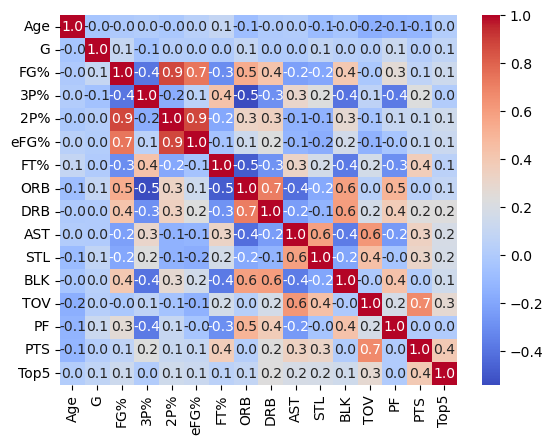

In [14]:
# Why each column is dropped (reasons are different from binary classification for predicting if top 5 candidate or not):
# Share (out of max votes): MVP voting stat that would artificially skew better results,   Season: Unnecessary,   VotingRank: would skew result,    Player & ID: encoding would result in too many features,
# Pos(position): MVP is positionless,   Tm(Team): too much variation between seasons,   GS: filtered players will mostly be starters,   MP: Depends on coaching,   
# FG, FGA, 3P, 3PA, 2P, 2PA, FT, FTA: Similar meaning to % (when adjusted for volume),   TRB: Sum of ORB & DRB
BasicStats_2 = BasicStatsFiltered.drop(columns = ["Share", "Season", "VotingRank", "Player", "PlayerID", "Pos", "Tm", "GS", "MP", "FG", "FGA", "3P", "3PA", "2P", "2PA", "FT", "FTA", "TRB"])
sns.heatmap(BasicStats_2.corr(), annot=True, fmt=".1f", cmap="coolwarm")

 <span style="color:lightblue"> Looking at variable correlations, although no single feature really stands out compared to Top5, there is a slight positive correlation with most stats, which likely indicates that higher stats = more likely to be top5 nominee, although this could be within margin of error, and TOV also having a slight correlation might indicate it is just correlated with player usage.<br><br> It is also neat to notice the positive correlation between Steals and Assists; stats that point guards typically accumulate. A similar trend occurs with ORB, DRB, & BLK; stats centers tend to accumulate, and a negative correlation between them and FT% & 3P%; areas that centers typically struggle with.<br><br><br>

### **Only Players Finishing in Top5 MVP Voting, includes VotingRank integer 1-5**

<Axes: >

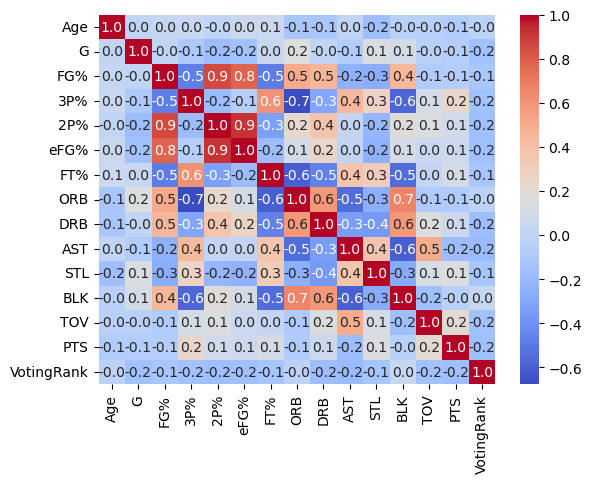

In [15]:
# Why each column is dropped (reasons are different from binary classification for predicting if top 5 candidate or not):
# Share (out of max votes): MVP voting stat that would artificially skew better results,   Season: Unnecessary,   Top5: All True,    Player & ID: encoding would result in too many features,
# Pos(position): MVP is positionless,   Tm(Team): too much variation between seasons,   GS: All top5 candidates are starters,   MP: Depends on coaching,   
# FG, FGA, 3P, 3PA, 2P, 2PA, FT, FTA: Similar meaning to % (when adjusted for volume),   TRB: Sum of ORB & DRB,   PF(fouls): doesn't typically impact voting
BasicStatsTop5_2 = BasicStatsTop5.drop(columns=["Share", "Season", "Top5", "Player", "PlayerID", "Pos", "Tm", "GS", "MP", "FG", "FGA", "3P", "3PA", "2P", "2PA", "FT", "FTA", "TRB", "PF"])
sns.heatmap(BasicStatsTop5_2.corr(), annot=True, fmt=".1f", cmap="coolwarm")

<span style="color:lightblue"> Looking at variable correlations no single feature really stands out compared to VotingRank, there is a slight negative correlation with most stats, which likely indicates that better stats = better ranking (voting rank is 1-5, so higher(better excluding TOV) stats correlates negatively with higher(worse) rank), although this could be within margin of error<br><br><br>

_____

# <span style="color:lightcoral"><u>**Model Building**

## <span style="color:lightcoral">**Top5 Candidate Classification Model**

### **Basic Stats Train Test Split for Classification**

In [16]:
Basic_X = BasicStats_2.drop(columns="Top5").to_numpy()
Basic_y = BasicStats_2["Top5"]
Basic_X_train, Basic_X_test, Basic_y_train, Basic_y_test = train_test_split(Basic_X, Basic_y, test_size=0.2)

### **Baseline classification model that predicts Top5 for all players as false**

In [17]:
basic_baseline_y_pred = np.full(len(Basic_y_test), False)
report = classification_report(Basic_y_test, basic_baseline_y_pred, zero_division=0.0)
print(report)

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       936
        True       0.00      0.00      0.00        38

    accuracy                           0.96       974
   macro avg       0.48      0.50      0.49       974
weighted avg       0.92      0.96      0.94       974



### **Basic Stats Classification Models**

In [18]:
Log_Reg = linear_model.LogisticRegression(max_iter=1000)

Log_Reg.fit(Basic_X_train, Basic_y_train)

Basic_y_pred = Log_Reg.predict(Basic_X_test)
# classification report from true and predicted values for Top5
report = classification_report(Basic_y_test, Basic_y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       936
        True       0.72      0.55      0.63        38

    accuracy                           0.97       974
   macro avg       0.85      0.77      0.81       974
weighted avg       0.97      0.97      0.97       974



## <span style="color:lightcoral">**Top5 Ranking Regression Model**

### **Basic Stats Train Test Split for Regression**

In [19]:
BTop5_X = BasicStatsTop5_2.drop(columns="VotingRank").to_numpy()
BTop5_y = BasicStatsTop5_2["VotingRank"]
BTop5_X_train, BTop5_X_test, BTop5_y_train, BTop5_y_test = train_test_split(BTop5_X, BTop5_y, test_size=0.2)

### **Baseline regression model that predicts random value 1-5**

In [20]:
BTop5_baseline_y_pred = np.random.randint(low=1, high=6, size=len(BTop5_y_test))

print("mean baseline accuracy:", np.sum(BTop5_baseline_y_pred == BTop5_y_test)/len(BTop5_y_test))
print("mean baseline guess r^2:", r2_score(BTop5_y_test, BTop5_baseline_y_pred))
print("mean baseline guess MAE:", mean_absolute_error(BTop5_y_test, BTop5_baseline_y_pred))
print("mean baseline guess MSE:", mean_squared_error(BTop5_y_test, BTop5_baseline_y_pred))

mean baseline accuracy: 0.14285714285714285
mean baseline guess r^2: -0.9724924521972491
mean baseline guess MAE: 1.5238095238095237
mean baseline guess MSE: 3.3333333333333335


### **Basic Stats Regression Models**

In [21]:
Lin_Reg = linear_model.LinearRegression()

Lin_Reg.fit(BTop5_X_train, BTop5_y_train)
BTop5_y_pred = Lin_Reg.predict(BTop5_X_test)
# classification report from true and predicted values for Top5
print("mean logreg accuracy:", np.sum(BTop5_y_pred == BTop5_y_test)/len(BTop5_y_test))
print("mean logreg guess r^2:", r2_score(BTop5_y_test, BTop5_y_pred))
print("mean logreg guess MAE:", mean_absolute_error(BTop5_y_test, BTop5_y_pred))
print("mean logreg guess MSE:", mean_squared_error(BTop5_y_test, BTop5_y_pred))


mean logreg accuracy: 0.0
mean logreg guess r^2: 0.018369103268966458
mean logreg guess MAE: 1.0556544822224425
mean logreg guess MSE: 1.6588671786594167
